# Part III - C: Analyzing Changing Trends in Academia - Journal Trends

## 3. Journal  Dynamics
In the previous notebook, we reviewed how papers' properties and authors' publication behaviors have changed over time. In this notebook, we going to utilize the SJR and MAG datasets to observe how journals' properties have changed over the last two centuries. First, let's load the required packages.

In [1]:
from configs import *
import pandas as pd
import numpy as np
import altair as alt
alt.renderers.enable('notebook')
from visualization.visual_utils import *
import turicreate.aggregate as agg

/home/michael/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/michael/anaconda2/lib/python2.7/site-packages/entrypoints.py:171: DeprecationWarning: You passed a bytestring as `filenames`. This will not work on Python 3. Use `cp.read_file()` or switch to using Unicode strings across the board.
  cp.read(path)
/home/michael/anaconda2/lib/python2.7/importlib/__init__.py:37: DeprecationWarning: The vega3 module is deprecated. Use vega instead.
  __import__(name)


### 3.1 Number of Journals over Time

In this section, we will examine how the number of journals has changed over time. Let's start by exploring the number of active journals each year, and also the number of new journals added each year.

In [2]:
j_sf = tc.load_sframe(EXTENDED_PAPERS_SFRAME)['Paper publish year','Journal ID mapped to venue name','Normalized venue name','Original venue name',"Paper ID"]
j_sf = j_sf[j_sf['Journal ID mapped to venue name'] != '']
j_sf = j_sf.rename({"Journal ID mapped to venue name": "Journal ID", 'Paper publish year': "Year"})
j_sf

Year,Journal ID,Normalized venue name,Original venue name,Paper ID
2008,0655F58A,icoin,international conferenceon information networ ...,7CF1E376
2012,08D7401B,ppopp,acm sigplan symposium onprinciples and practice ...,7A21777D
1999,08D7401B,ppopp,acm sigplan symposium onprinciples and practice ...,8132F9B1
1991,08D7401B,ppopp,acm sigplan symposium onprinciples and practice ...,7C74C2D1
1993,08D7401B,ppopp,acm sigplan symposium onprinciples and practice ...,7FDBE7A5
1995,08D7401B,ppopp,acm sigplan symposium onprinciples and practice ...,80DC91D5
1995,08D7401B,ppopp,acm sigplan symposium onprinciples and practice ...,807C58E9
1995,08D7401B,ppopp,acm sigplan symposium onprinciples and practice ...,80518538
1999,08D7401B,ppopp,acm sigplan symposium onprinciples and practice ...,7D01402A
2012,08D7401B,ppopp,acm sigplan symposium onprinciples and practice ...,8092C992


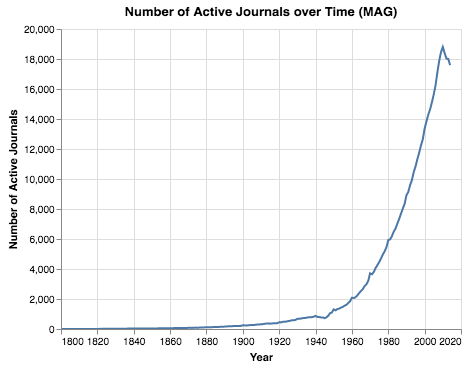

In [3]:
g = j_sf.groupby("Year", {"Number of Active Journals": agg.COUNT_DISTINCT("Journal ID")})
draw_features_yearly_chart(g, "Number of Active Journals", 1800, 2014, title="Number of Active Journals over Time (MAG)")                 

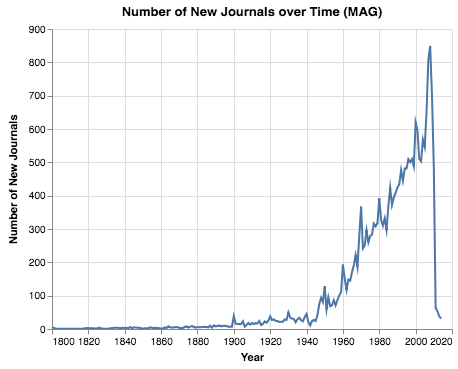

In [4]:
j_start_sf = j_sf.groupby('Journal ID', {"Start Year": agg.MIN("Year")})
g = j_start_sf.groupby("Start Year", {"Number of New Journals": agg.COUNT()})
draw_features_yearly_chart(g.rename({"Start Year": "Year"}), "Number of New Journals", 1800, 2014,  title="Number of New Journals over Time (MAG)")

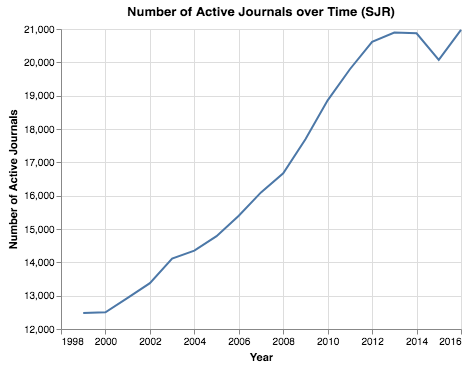

In [5]:
sjr_sf = tc.load_sframe(SJR_SFRAME)["Rank", "Year", "Title", "Type", "SJR", "SJR Best Quartile", "H index","Total Docs.", "Cites / Doc. (2years)"]
sjr_sf = sjr_sf[sjr_sf['Type'] == 'journal']
sjr_sf = sjr_sf.unique()
sf = sjr_sf[sjr_sf["Total Docs."] > 0]
g = sf.groupby("Year", {"Number of Active Journals": agg.COUNT_DISTINCT("Title")})
draw_features_yearly_chart(g, "Number of Active Journals", 1999, 2016, title="Number of Active Journals over Time (SJR)")                 

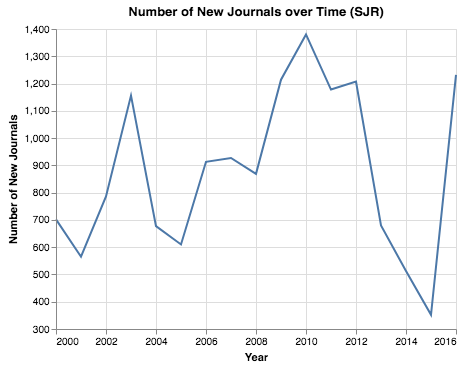

In [6]:
g = sjr_sf.groupby("Title", {"Start Year": agg.MIN("Year")})
g2 = g.groupby("Start Year", {"Number of New Journals": agg.COUNT()})
# We will skip on the year 1999 that contains journals that were first published before 1999
draw_features_yearly_chart(g2.rename({"Start Year": "Year"}), "Number of New Journals", 2000, 2016, title="Number of New Journals over Time (SJR)")

According to both datasets, there are over 14,000 active journals in each year since 2010, and according to SJR there were 20,975 active journals in 2015. Moreover, in both datasets, we discovered a sharp increase in the number of new journals, followed by a decrease in new journals; in the MAG dataset the decrease started in 2009, and in the SJR dataset it started in 2011. Interestingly enough, according to the SJR dataset, which seems to have more accurate data for the last decade, in 2010 there were 1380 new journals, while in 2015 there were only 352 new journals. We believe that this can be a direct result of the publishing of mega-journals, such as PLOS ONE that changed the academic publications eco-system. However, in 2016 the number of new journals had recovered with 1232 new journals. Nevertheless, the number of active journals has skyrocketed over the last 50 years.

Let's observe the average number of published papers for journals over time using both datasets.


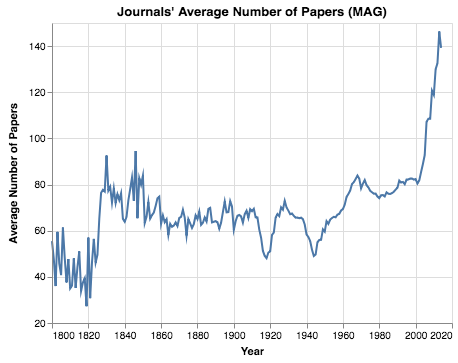

In [7]:
sf = j_sf.groupby(["Journal ID", "Year"], {"Number of Papers": agg.COUNT()})
g = sf.groupby('Year', {"Average Number of Papers": agg.AVG("Number of Papers")})
draw_features_yearly_chart(g, "Average Number of Papers", 1800, 2014, title="Journals' Average Number of Papers (MAG)")

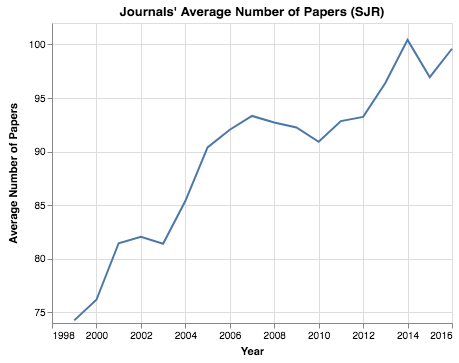

In [8]:
sjr_g = sjr_sf.groupby("Year", {"Average Number of Papers": agg.AVG("Total Docs.")})
draw_features_yearly_chart(sjr_g,  "Average Number of Papers", 1999, 2016, title="Journals' Average Number of Papers (SJR)")

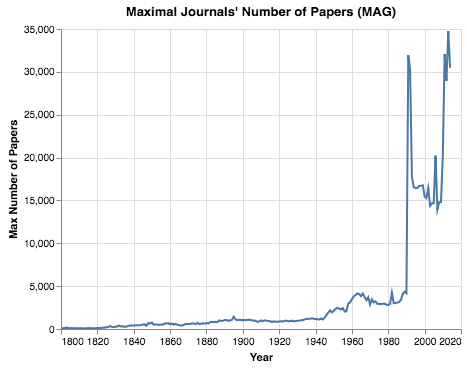

In [9]:
sf = j_sf.groupby(["Journal ID", "Year", 'Original venue name'], {"Number of Papers": agg.COUNT()})
g = sf.groupby('Year', {"Max Number of Papers": agg.MAX("Number of Papers")})
draw_features_yearly_chart(g, "Max Number of Papers", 1800, 2014, title="Maximal Journals' Number of Papers (MAG)")

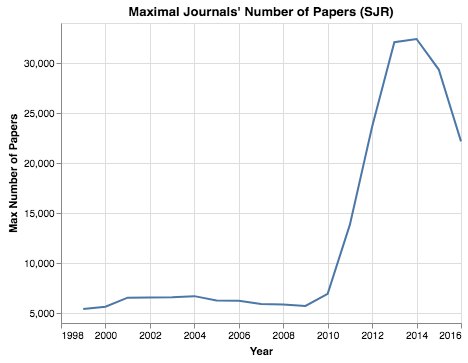

In [10]:
sjr_g = sjr_sf.groupby("Year", {"Max Number of Papers": agg.MAX("Total Docs.")})
draw_features_yearly_chart(sjr_g, "Max Number of Papers", 1999, 2016, title="Maximal Journals' Number of Papers (SJR)")

In [11]:
sf = sjr_sf[sjr_sf["Year"] == 2014 ]
sf.sort("Total Docs.", ascending=False)['Title', 'Total Docs.']

Title,Total Docs.
PLoS ONE,32402
RSC Advances,8476
Journal of Physics:Conference Series ...,5907
Applied Physics Letters,5022
Physical Review B -Condensed Matter and ...,4898
"Methods in molecularbiology (Clifton, N.J.) ...",4631
Journal of AppliedPhysics ...,4207
Proceedings of theNational Academy of ...,4205
Economist,4070
Key Engineering Materials,4065


In [12]:
sf = sjr_sf[sjr_sf["Year"] == 1999 ]
sf.sort("Total Docs.", ascending=False)['Title', 'Total Docs.']

Title,Total Docs.
Journal of BiologicalChemistry ...,5397
Physical Review B -Condensed Matter and ...,4556
SAE Technical Papers,2902
Lancet,2894
Proceedings of theNational Academy of ...,2830
Journal of AppliedPhysics ...,2738
Physical Review Letters,2696
British Medical Journal,2645
Applied Physics Letters,2585
Journal of ChemicalPhysics ...,2547


In [13]:
sf = sjr_sf[sjr_sf["Year"] == 2016 ]
sf = sf[sf["Total Docs."] >= 1000]
sf.materialize()
sf


Cites / Doc. (2years),H index,Rank,SJR,SJR Best Quartile,Title,Total Docs.
0.03,7,28587,0.1,Q4,TLS - The Times LiterarySupplement ...,1362
3.5,120,2539,1.363,Q1,Organic and BiomolecularChemistry ...,1196
4.76,192,2558,1.357,Q1,Electrochimica Acta,2471
0.89,38,15079,0.23,Q3,Journal of Computationaland Theoretical ...,1533
8.78,176,578,3.051,Q1,Renewable and SustainableEnergy Reviews ...,1354
4.95,134,1267,1.999,Q1,Energy,1619
3.81,282,2043,1.55,Q1,Langmuir,1542
3.82,85,4918,0.872,Q2,International Journal ofBiological Macromolec ...,1216
2.73,62,5159,0.834,Q1,Materials,1026
3.89,88,1719,1.706,Q2,Molecular Neurobiology,1061


From above results, not only has the number of active journals sharply increased over the years, but also on average there is an increase in the number of papers published in journals, where there are various high-ranked journals which publish thousands of papers each year.

### 3.2 Journal Ranking Trends

There are various methods to measure a journal’s success, such as the journal's SJR, impact factor, H-index, journal quartile, etc. Let's try to use the SJR dataset to determine how this measure has changed since 1999. We will start by measuring how the number of papers in each quartile has changed over time.

In [14]:
sf = sjr_sf["Year", "SJR Best Quartile","Total Docs."]
g = sf.groupby(["Year", "SJR Best Quartile"], {"Papers Number": agg.SUM("Total Docs.")})
g = g.sort(["Year", "SJR Best Quartile"])

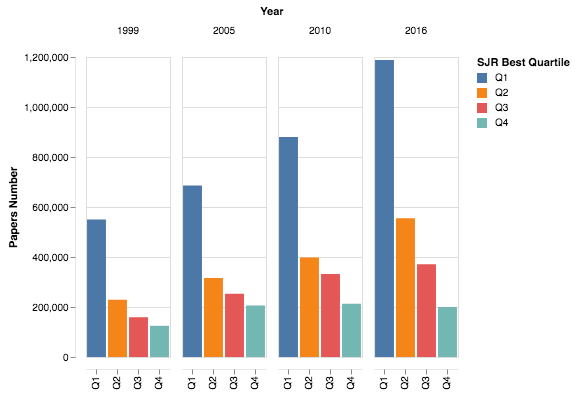

In [15]:
selected_years = {1999, 2005, 2010,2016}
g2 = g[g["Year"].apply(lambda y: y in selected_years)]
alt.Chart(g2.to_dataframe()).mark_bar(stroke='transparent').encode(
    alt.X('SJR Best Quartile:N', title=""),
    alt.Y("Papers Number:Q",axis=alt.Axis(grid=True)),
    color='SJR Best Quartile:N',
    column="Year:O",
).configure_axis(
    domainWidth=0.2)

It can be observed that over the last few years the number of papers which were published in Q1 and Q2 journals more than doubled, from 550,109 Q1 papers and 229,373 Q2 papers in 1999, to 1,187,514 Q1 papers and 554,782 Q2 papers in 2016. Let's calculate the percentage of papers in each quartile in 2016:

In [16]:
g3 = g.groupby("Year", {"Total Papers": agg.SUM("Papers Number")})
g3 = g.join(g3,on="Year")
g3["Percentage of Papers"] = g3.apply(lambda r: r['Papers Number']/float(r['Total Papers']))
g3 = g3[g3["Year"] == 2016]
g3 = g3.sort(["Year", "SJR Best Quartile"])
g3

SJR Best Quartile,Year,Papers Number,Total Papers,Percentage of Papers
Q1,2016,1187514,2313231,0.513357291165
Q2,2016,554782,2313231,0.239829917548
Q3,2016,371076,2313231,0.160414588945
Q4,2016,199859,2313231,0.0863982023412


From the above results we can observe that over 51.3% (1.18 million papers) of the published papers were published in Q1 journals, while only 8.6% of the papers were published in Q4. Let's observe how the H-index has changed over the years.

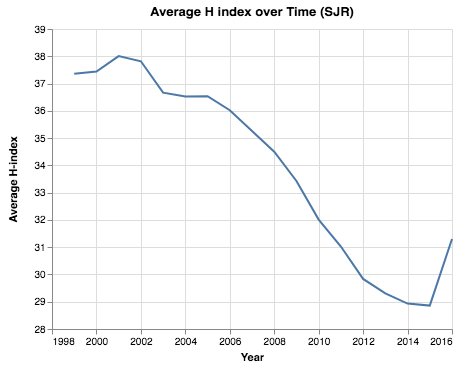

In [17]:
sf = sjr_sf["Year", "H index"]
g = sf.groupby("Year", {"Average H-index": agg.AVG("H index")})
draw_features_yearly_chart(g, "Average H-index", 1999, 2016, title="Average H index over Time (SJR)")

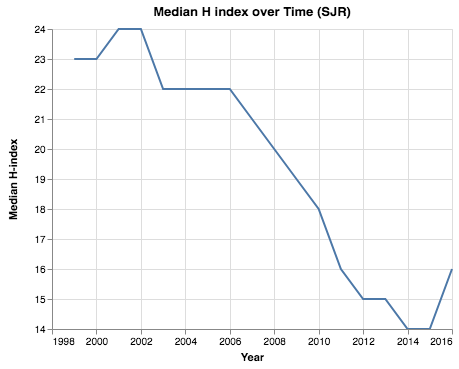

In [18]:
g = sf.groupby("Year", {"H-index List": agg.CONCAT("H index")})
g["Median H-index"] = g["H-index List"].apply(lambda l: np.median(l))
g = g.remove_column("H-index List")
draw_features_yearly_chart(g, "Median H-index", 1999, 2016, title="Median H index over Time (SJR)")


[(0, 200)]

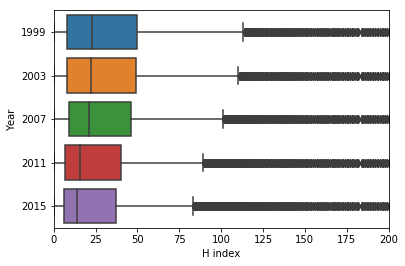

In [19]:
selected_years = {1999, 2003,2007,2011, 2015}
g = sf[sf["Year"].apply(lambda y: y in selected_years )]
s = sns.boxplot(y="Year", x="H index", data=g.to_dataframe(), orient="h")
s.set(xlim=(0, 200))

According to the above charts, we can notice that with time the H-index has decreased, and since 2012 only half of the journals have an H-index equal to or less than 16. This result may indicate that many of the journals have limited impact. Moreover, mega-journals, such as PLOS ONE have a very high H-index value due to the fact that they publish tens of thousands of papers each year. Let's measure how the $\frac{Cites}{Docs} (2years)$ and SJR measures have changed over time.

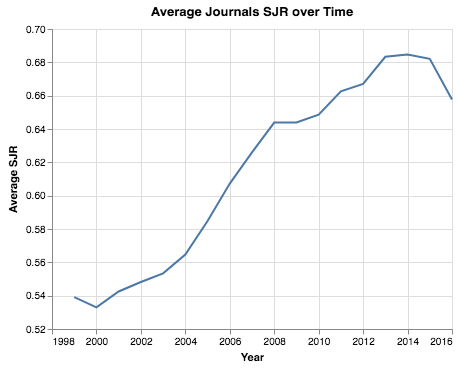

In [20]:
sf = sjr_sf["Year", "SJR"]
g = sf.groupby("Year", {"Average SJR": agg.AVG("SJR")})
draw_features_yearly_chart(g, "Average SJR", 1999, 2016, title="Average Journals SJR over Time")

[(0, 2)]

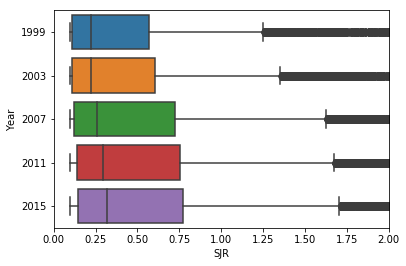

In [21]:
selected_years = {1999, 2003,2007,2011, 2015}
g = sf[sf["Year"].apply(lambda y: y in selected_years )]
s = sns.boxplot(y="Year", x="SJR", data=g.to_dataframe(), orient="h")
s.set(xlim=(0, 2))

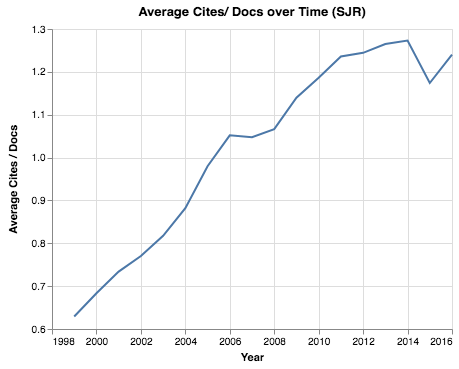

In [22]:
sf = sjr_sf["Year", "Cites / Doc. (2years)"]
g = sf.groupby("Year", {"Average Cites / Docs": agg.AVG("Cites / Doc. (2years)")})
draw_features_yearly_chart(g, "Average Cites / Docs", 1999, 2016, title="Average Cites/ Docs over Time (SJR)")

[(0, 2)]

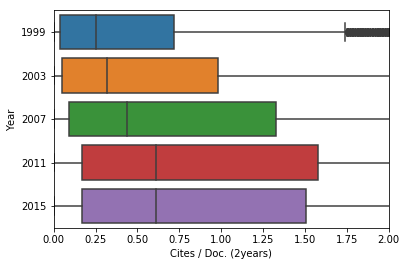

In [23]:
selected_years = {1999, 2003,2007,2011, 2015}
g = sf[sf["Year"].apply(lambda y: y in selected_years )]
s = sns.boxplot(y="Year", x="Cites / Doc. (2years)", data=g.to_dataframe(), orient="h")
s.set(xlim=(0, 2))

It can be observed that both the H-index, $\frac{Cites}{Docs} (2years)$, and SJR measures have changed considerably since 1999. While the H-index has decreased sharply, the $\frac{Cites}{Docs}$ has increased sharply over the period of 18 years. These may indicate that these measures are much less effective than in the past to measure journal ranking, especially when taking into consideration the surge in the number of active journals and the emerging of mega-journals.
The SJR measure has also changed over the last 18 years. However, as can be seen from the above charts, the change was less dramatic.


### 3.3 Top Journal Trends

In this section, we are going to analyze how various properties have changed in the top-40 journals. Let's start by selecting the top-40 journals.

In [24]:
sf = sjr_sf[sjr_sf["Year"] == 2016]
sf = sf.sort("SJR", ascending=False)[:40]
top_journals_titles = set(sf["Title"])
sf["Title"]

dtype: str
Rows: 40
['CA - A Cancer Journal for Clinicians', 'Nature Reviews Genetics', 'Nature Reviews Immunology', 'Nature Reviews Molecular Cell Biology', 'Annual Review of Immunology', 'Cell', 'Quarterly Journal of Economics', 'Reviews of Modern Physics', 'Annual Review of Astronomy and Astrophysics', 'Nature Reviews Cancer', 'Journal of Finance', 'Nature Genetics', 'Nature Biotechnology', 'Annual Review of Biochemistry', 'Nature Methods', 'Chemical Reviews', 'Nature Reviews Neuroscience', 'Nature Nanotechnology', 'Nature', 'Nature Materials', 'Physiological Reviews', 'Immunity', 'Nature Photonics', 'New England Journal of Medicine', 'Annual Review of Condensed Matter Physics', 'Chemical Society Reviews', 'Review of Economic Studies', 'Nature Reviews Microbiology', 'Nature Immunology', 'Econometrica', 'MMWR. Recommendations and reports : Morbidity and mortality weekly report. Recommendations and reports / Centers for Disease Control', 'Nature Medicine', 'Nature Cell Biology', 'Natu

Let's get these journals’ ISSNs (there can be several ISSNs for each journal) and match them to the journal IDs in the MAG dataset.

In [25]:
sf = tc.load_sframe(SJR_SFRAME)["Title","ISSN"]
sf = sf[sf["ISSN"] != None ]
top_journals_issn = set(sf[sf["Title"].apply(lambda t: t in top_journals_titles)]["ISSN"]) # the journals ISSN over the years

#let's match the top journals to the MAG dataset journals by matching ISSNs and names
join_sf = tc.load_sframe(AMINER_MAG_JOIN_SFRAME)["Original venue name", "Journal ID mapped to venue name", "issn"]
join_sf = join_sf[join_sf["issn"] != None]
join_sf = join_sf[join_sf["issn"] != '']
join_sf = join_sf[join_sf["Journal ID mapped to venue name"] != '']
join_sf["issn"] = join_sf["issn"].apply(lambda issn: issn.replace("-", ""))
join_sf = join_sf[join_sf["issn"].apply(lambda issn: issn in top_journals_issn)]
join_sf = join_sf[join_sf["Original venue name"].apply(lambda t: t in top_journals_titles)]
selected_mag_journals = join_sf["Original venue name", "Journal ID mapped to venue name" ].unique()
selected_mag_journals

Journal ID mapped tovenue name ...,Original venue name
079E7DE4,Nature Methods
07A3050E,Cell Stem Cell
008282E5,Nature Reviews Genetics
090B6496,Nature Cell Biology
05B0AD9A,Econometrica
003B355D,Science
06315123,Nature Materials
00775C57,Nature Nanotechnology
045DDE15,Reviews of Modern Physics
0838449D,Nature Genetics


At the end of the matching process, we succeeded in matching 30 top journals in the MAG dataset based on their SJR matching ranking. Let's deeply examine how various properties of these journals have changed over time. We will start by looking in general at journal features, such as author’s age, gender, etc., based on all papers in all 30 journals.

In [26]:
top_journal_ids_set = set(selected_mag_journals["Journal ID mapped to venue name"])
mag_sf = tc.load_sframe(EXTENDED_PAPERS_SFRAME)["Paper ID","Journal ID mapped to venue name","Paper publish year", "Ref Number" ]
select_papers_sf = mag_sf[mag_sf["Journal ID mapped to venue name"].apply(lambda i: i in top_journal_ids_set)]
select_papers_sf = select_papers_sf[select_papers_sf["Paper publish year"] <= 2014]
select_papers_sf = select_papers_sf[select_papers_sf["Paper publish year"] >= 1950]
select_papers_sf = select_papers_sf[select_papers_sf["Ref Number"] >= 5]
len(select_papers_sf)

110825

In [27]:
#Let's load all the papers into a PaperCollection object for analysis
from papers_collection_analyer import *
papers_ids = list(select_papers_sf["Paper ID"])
pc = PapersCollection(papers_ids=papers_ids )

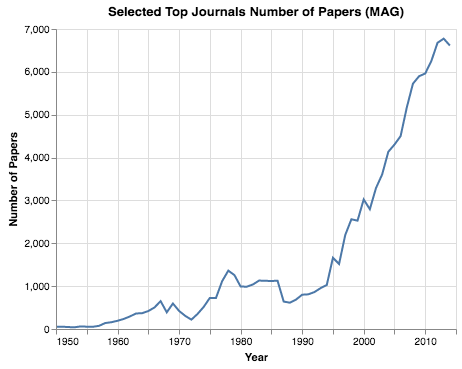

In [28]:
#This can take some time
logger.setLevel(logging.INFO) # don't print the debugging info
d = pc.calculate_feature_over_time("papers_number", 1950, 2014)
d = d['papers_number']
sf = tc.SFrame({"Year": d.keys(), "Number of Papers": d.values()})
draw_features_yearly_chart(sf, "Number of Papers", 1950, 2014, title="Selected Top Journals Number of Papers (MAG)")                 

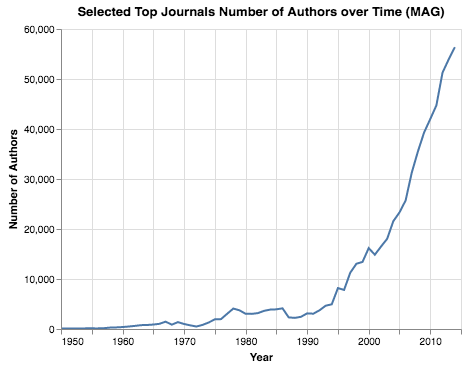

In [29]:
d = pc.calculate_feature_over_time("authors_number", 1950, 2014)
d = d['authors_number']
sf = tc.SFrame({"Year": d.keys(), "Number of Authors": d.values()})
draw_features_yearly_chart(sf, "Number of Authors", 1950, 2014, title="Selected Top Journals Number of Authors over Time (MAG)")                 

Let's examine how authors’ average ages have changed over time.


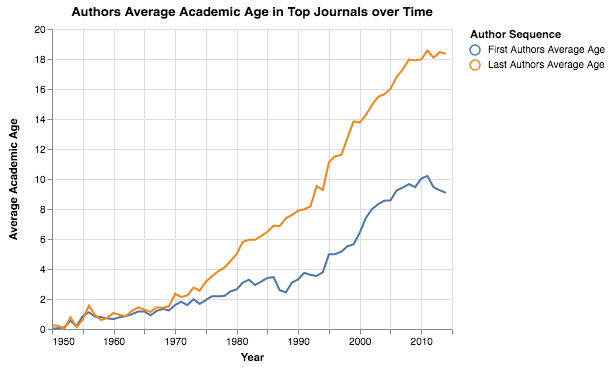

In [30]:
d = pc.calculate_feature_over_time("first_authors_average_age", 1950, 2014)
d = d['first_authors_average_age']
first_sf = tc.SFrame({"Year": d.keys(), "First Authors Average Age": d.values()})

d = pc.calculate_feature_over_time("last_authors_average_age", 1950, 2014)
d = d['last_authors_average_age']
last_sf = tc.SFrame({"Year": d.keys(), "Last Authors Average Age": d.values()})

sf = first_sf.join(last_sf, on="Year", how="left")
draw_features_yearly_chart_multi_lines(sf, "Author Sequence", "Average Academic Age", 1950, 2014, title="Authors Average Academic Age in Top Journals over Time")                 

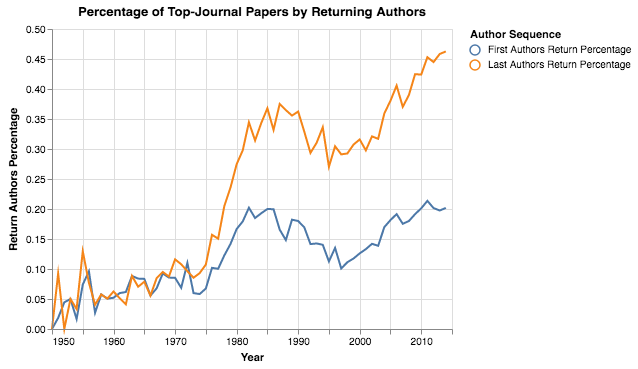

In [31]:
d = pc.calculate_feature_over_time("percentage_of_papers_with_first_authors_that_publish_before_in_the_same_venue", 1950, 2014)
d = d['percentage_of_papers_with_first_authors_that_publish_before_in_the_same_venue']
first_sf = tc.SFrame({"Year": d.keys(), "First Authors Return Percentage": d.values()})


d = pc.calculate_feature_over_time("percentage_of_papers_with_last_authors_that_publish_before_in_the_same_venue", 1950, 2014)
d = d['percentage_of_papers_with_last_authors_that_publish_before_in_the_same_venue']
last_sf = tc.SFrame({"Year": d.keys(), "Last Authors Return Percentage": d.values()})

sf = first_sf.join(last_sf, on="Year", how="left")
draw_features_yearly_chart_multi_lines(sf, "Author Sequence", "Return Authors Percentage", 1950, 2014, title="Percentage of Top-Journal Papers by Returning Authors")                 


From the above charts, we can observe that the average age of first and last author that published in the top-30 journals we selected increased sharply. For example, in 1990 the average academic age of last authors who published papers in these journals was 7.89 years, while in 2014 it was 18.35 years. A similar observation can be made regarding returning authors; in 1990 38% of papers' last authors had published in these top journals before, while in 2014 the percentage jumped to 46.2%.
It worthwhile to take into consideration that not all of these top-30 journals were as highly ranked in 1990 as they have become in recent years. Let's observe similar statistics, this time on each journal  separately, using the Venue class.

In [32]:
#Let's get venues details
sf = VENUE_FETCHER.get_valid_venues_papers_ids_sframe(min_ref_number=5, min_journal_papers_num=50) 
sf = sf.join(selected_mag_journals, on='Journal ID mapped to venue name')
sf

Journal ID mapped tovenue name ...,Count,Journal name,Paper IDs List,Original venue name
0590C518,1035,nature reviews immunology,"[7D640933, 765F2C22,7700AA0B, 76190870, ...",Nature Reviews Immunology
06954C9D,17034,cell,"[7D51DD43, 7597ABFA,76E80A08, 772565EE, ...",Cell
079E7DE4,1766,nature methods,"[7E51EE0D, 76C89A04,778D8956, 7728C2C7, ...",Nature Methods
0004D416,3009,chemical society reviews,"[77A3264A, 7D75A048,7DA181DF, 755B4EBF, ...",Chemical Society Reviews
05B0AD9A,941,econometrica,"[7E4970EC, 77F51B50,77C77C9D, 76E42D63, ...",Econometrica
045DDE15,90,reviews of modern physics,"[7F807BDE, 791B915D,7E731DEA, 7D019254, ...",Reviews of Modern Physics
0C1D733E,5180,nature medicine,"[766B176F, 7561AF20,69494EC8, 7EA45985, ...",Nature Medicine
00775C57,1238,nature nanotechnology,"[76E1BD47, 75AB81CE,7721BDEE, 7E59160D, ...",Nature Nanotechnology
0335D7A3,580,annual review ofbiochemistry ...,"[76993443, 757A2205,7E6135BE, 7F26BFAB, ...",Annual Review ofBiochemistry ...
0362BB51,1014,nature reviewsmicrobiology ...,"[76FA8E47, 75BCFB6F,7590F85A, 75B375B6, ...",Nature ReviewsMicrobiology ...


In [33]:
from venue import Venue
venue_dict = {}

#create dict with venue object
for r in sf:
    venue_id = r['Journal ID mapped to venue name']
    venue_name = r["Original venue name"]
    papers_ids = r['Paper IDs List']
    venue_dict[venue_name] = Venue(venue_id=venue_id, venue_name=venue_name, papers_ids=papers_ids)

#Get selected journal features dict
features_dict = {}
features_list = ['papers_number', 
                 'authors_average_age', 'first_authors_average_age', 'last_authors_average_age', 
                   'percentage_of_papers_with_authors_that_publish_before_in_the_same_venue',
                   "percentage_of_papers_with_first_authors_that_publish_before_in_the_same_venue",
                   "percentage_of_papers_with_last_authors_that_publish_before_in_the_same_venue"]

#Create a feature sframe
features_dict = {
    'Venue Name': [],
    'Feature Name': [],
    'Year': [],
    'Value': []
}
for n, v in venue_dict.iteritems():
    for f in features_list:
        d = v.calculate_feature_over_time(f, 1980, 2014)[f]
        for y,val in d.iteritems():
            features_dict['Venue Name'].append(n)
            features_dict['Feature Name'].append(f)
            features_dict['Year'].append(y)
            features_dict['Value'].append(val)
sf = tc.SFrame(features_dict)

            

2018-07-21 01:21:57,055 [MainThread  ] [INFO ]  Consturcting a Venue object with the following params venue_id=0590C518, venue_name=Nature Reviews Immunology, issn_list=() 
2018-07-21 01:21:57,059 [MainThread  ] [INFO ]  Get SJR data of venue_name=Nature Reviews Immunology, issn_list=()
2018-07-21 01:21:57,075 [MainThread  ] [INFO ]  Consturcted a Venue object with 1035 papers
2018-07-21 01:21:57,077 [MainThread  ] [INFO ]  Consturcting a Venue object with the following params venue_id=06954C9D, venue_name=Cell, issn_list=() 
2018-07-21 01:21:57,079 [MainThread  ] [INFO ]  Get SJR data of venue_name=Cell, issn_list=()
2018-07-21 01:21:57,086 [MainThread  ] [INFO ]  Consturcted a Venue object with 17034 papers
2018-07-21 01:21:57,087 [MainThread  ] [INFO ]  Consturcting a Venue object with the following params venue_id=079E7DE4, venue_name=Nature Methods, issn_list=() 
2018-07-21 01:21:57,089 [MainThread  ] [INFO ]  Get SJR data of venue_name=Nature Methods, issn_list=()
2018-07-21 01:2

We created a features SFrame, and now we can see how each feature changed over time across all the selected top-ranked journals.

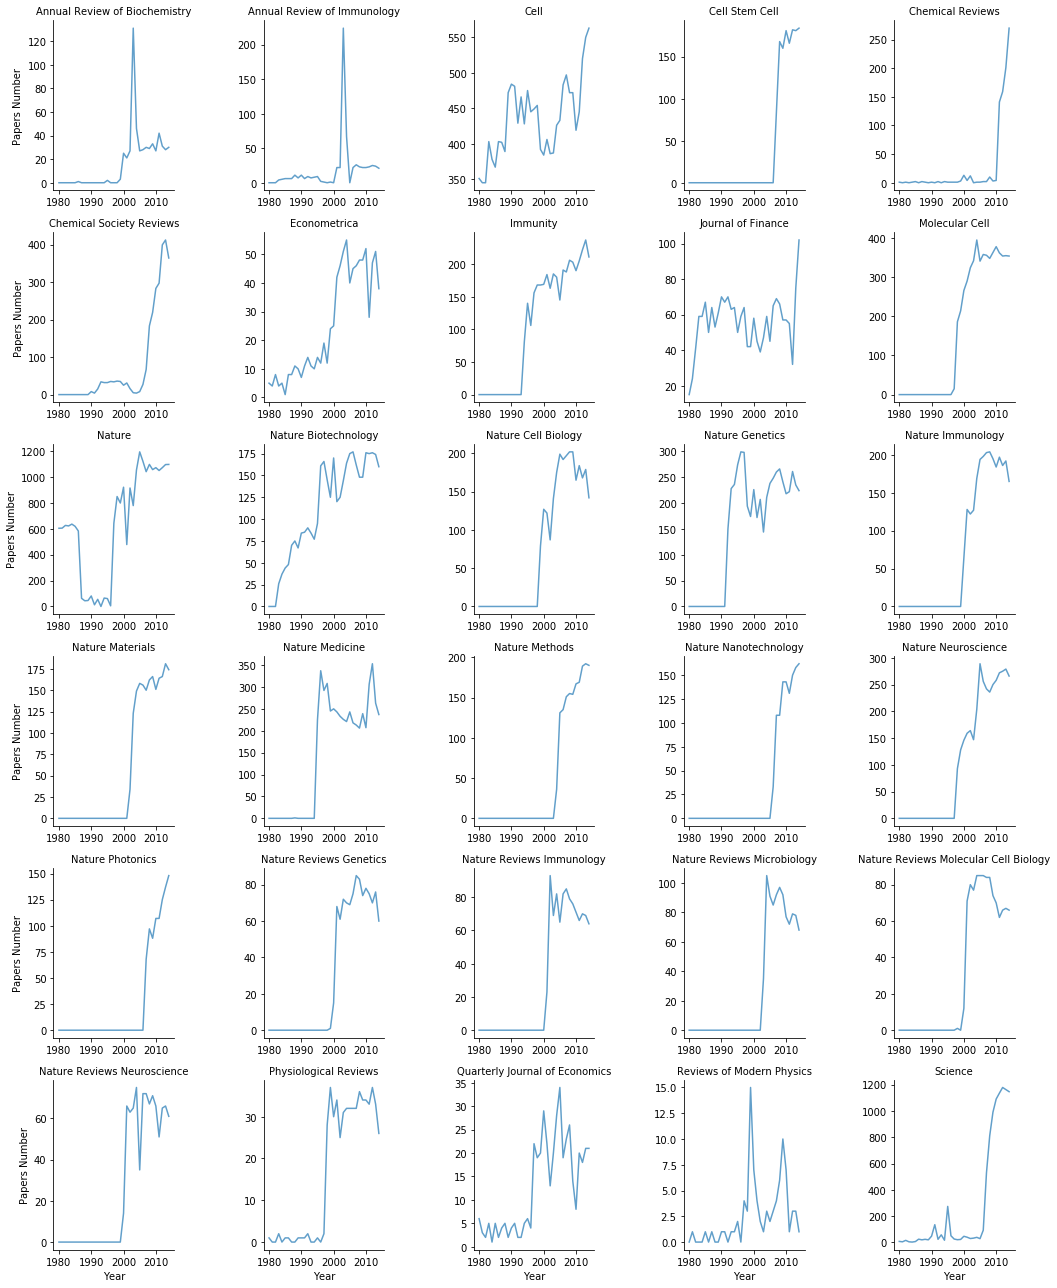

In [34]:
def draw_journal_feature(sf, features_set, hue=None, sharex=False, sharey=False, xlabel="Year", ylabel='',
                        hue_dict=None):
    sf = sf[sf['Feature Name'].apply(lambda s: s in features_set)]

    if hue_dict is not None:
         sf['Feature Name'] = sf['Feature Name'].apply(lambda f: hue_dict[f] if f in hue_dict else f)
    sf = sf.sort(["Venue Name", "Year", 'Feature Name'])
    df = sf.to_dataframe()
    if hue is None:
        c = sns.FacetGrid(df, col="Venue Name", sharex=sharex, sharey=sharey, col_wrap=5)
    else:
        
        c = sns.FacetGrid(df, col="Venue Name", hue=hue, sharex=sharex, sharey=sharey, col_wrap=5)
    c.map(plt.plot, "Year", "Value", alpha=.7).set_titles("{col_name}")
    if hue is not None:
        c.add_legend()
    c.set_axis_labels(xlabel, ylabel)
    
draw_journal_feature(sf, {"papers_number"}, ylabel='Papers Number')
    

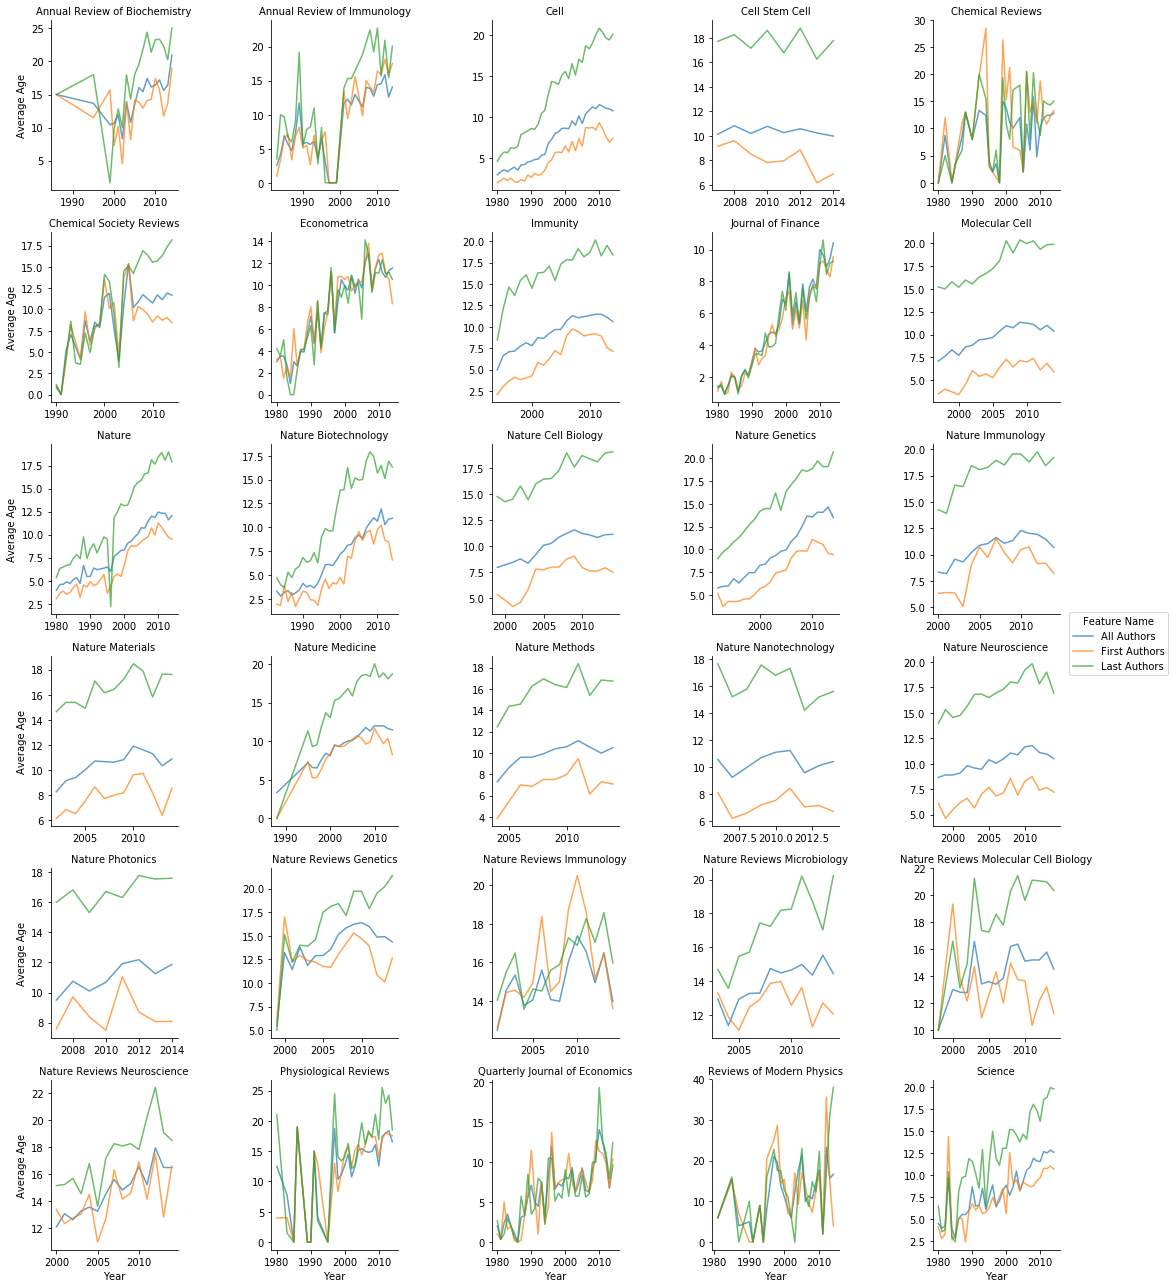

In [35]:
featurens_names_labels = {'authors_average_age': "All Authors", 'first_authors_average_age': 'First Authors',
                        'last_authors_average_age': 'Last Authors'}
draw_journal_feature(sf, {'authors_average_age', 'first_authors_average_age', 'last_authors_average_age'}, ylabel='Average Age', hue="Feature Name", hue_dict=featurens_names_labels)


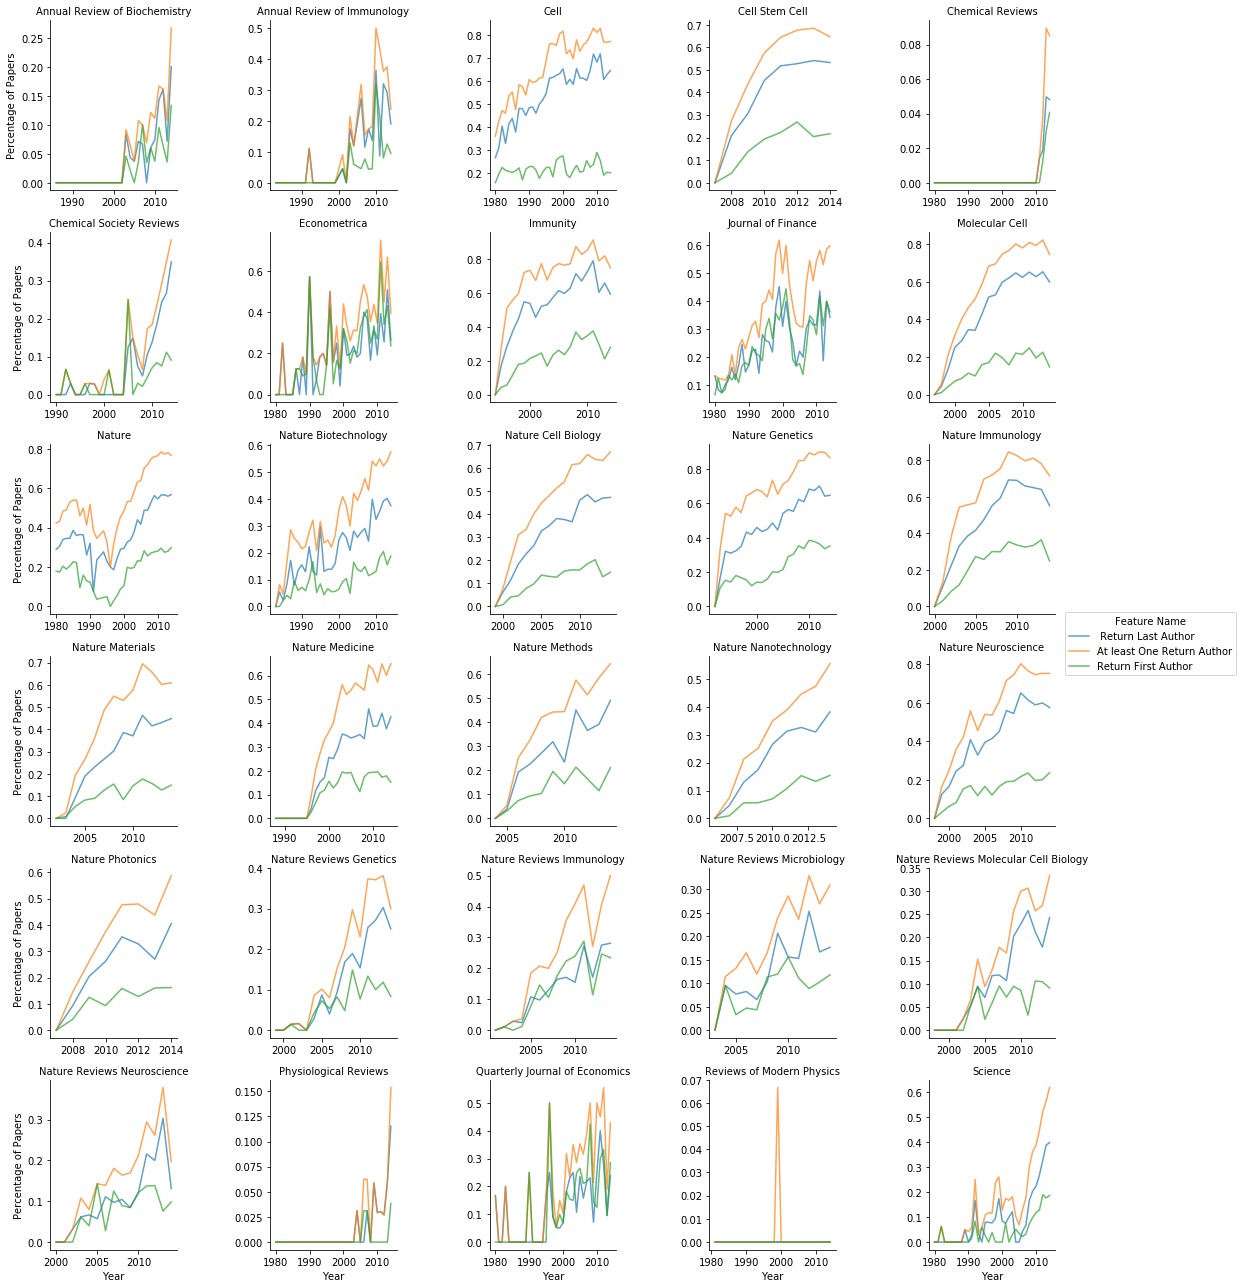

In [36]:
featurens_names_labels = {'percentage_of_papers_with_authors_that_publish_before_in_the_same_venue': 'At least One Return Author',
 "percentage_of_papers_with_first_authors_that_publish_before_in_the_same_venue": 'Return First Author',
 "percentage_of_papers_with_last_authors_that_publish_before_in_the_same_venue": ' Return Last Author'}

draw_journal_feature(sf, {'percentage_of_papers_with_authors_that_publish_before_in_the_same_venue', 'percentage_of_papers_with_first_authors_that_publish_before_in_the_same_venue', 'percentage_of_papers_with_last_authors_that_publish_before_in_the_same_venue'}, ylabel='Percentage of Papers', hue="Feature Name", hue_dict=featurens_names_labels)


In [37]:
x = sf[sf["Feature Name"] == 'percentage_of_papers_with_authors_that_publish_before_in_the_same_venue']
x = x[x["Venue Name"] == "Nature Genetics"]
x

Feature Name,Value,Venue Name,Year
percentage_of_papers_with_authors_that_publish ...,0.0,Nature Genetics,1992
percentage_of_papers_with_authors_that_publish ...,0.337719298246,Nature Genetics,1993
percentage_of_papers_with_authors_that_publish ...,0.542372881356,Nature Genetics,1994
percentage_of_papers_with_authors_that_publish ...,0.525547445255,Nature Genetics,1995
percentage_of_papers_with_authors_that_publish ...,0.578595317726,Nature Genetics,1996
percentage_of_papers_with_authors_that_publish ...,0.546979865772,Nature Genetics,1997
percentage_of_papers_with_authors_that_publish ...,0.644329896907,Nature Genetics,1998
percentage_of_papers_with_authors_that_publish ...,0.66091954023,Nature Genetics,1999
percentage_of_papers_with_authors_that_publish ...,0.681415929204,Nature Genetics,2000
percentage_of_papers_with_authors_that_publish ...,0.668604651163,Nature Genetics,2001


In [38]:
x[x["Year"] == 2014]

Feature Name,Value,Venue Name,Year
percentage_of_papers_with_authors_that_publish ...,0.866071428571,Nature Genetics,2014


From the above charts, we can observe that over the years most of the top journals have published more papers each year. Additionally, in all the selected journals the average career age of the published authors increased over the years. For example, the average career age of last authors in Nature journal increased from about 5 years in 1980 to about 17.5 years in 2014. Moreover, the percentage of papers with returning authors has increased sharply in recent years. For example, in Cell journal, in 2010, about 80% of all papers included at least one author who published in the journal before, while in 1980 this rate stood at less than 40%.